#Part 1

Create an apache spark environment and load the dataset provided. You may use CoLab or a jupyter notebook. Please create a table providing summary statistics of this dataset, i.e. mean values, range, standard deviations, min/max values, median values and 25%/50%/75% percentile values. Comment on whether there are any missing values present throughout. The column that contains the labels (normal/abnormal) should not be part of the table

In [227]:
pip install handyspark

In [228]:
from google.colab import drive 
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [229]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [230]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz

In [231]:
!tar xf spark-2.4.7-bin-hadoop2.7.tgz

In [232]:
!pip install -q findspark

In [233]:
#To find the GPU information allocated to play with run the below snippet of code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 11.5 GB  | Proc size: 205.5 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [234]:
import os
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"
import findspark
findspark.init()

In [235]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

In [236]:
#Importing Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [237]:
#Creating function to export spark dataframe to pandas
def export_table(spark_df):
  df = spark_df.toPandas()
  df = df.transpose()
  new_header = df.iloc[0]
  df = df[1:] #take the data less the header row
  df.columns = new_header #set the header row as the df header
  return df

In [238]:
#Convert XLSX to CSV
read_file = pd.read_excel ('/content/drive/MyDrive/Masters/Semester 2/Data Mining & Visualisation/Assessments/Assessment2/CS551G_DMV_Assessment_2_Dataset.xlsx')
data = spark.createDataFrame(read_file)
#read_file.to_csv ('/content/drive/MyDrive/Masters/Semester 2/Data Mining & Visualisation/Assessments/Assessment2/new_CS551G_DMV_Assessment_2_Dataset.csv', index = None, header=True)

/content/spark-2.4.7-bin-hadoop2.7/python/pyspark/sql/session.py:714: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  An error occurred while calling z:org.apache.spark.sql.api.python.PythonSQLUtils.readArrowStreamFromFile.
: java.lang.IllegalArgumentException
	at java.nio.ByteBuffer.allocate(ByteBuffer.java:334)
	at org.apache.arrow.vector.ipc.message.MessageSerializer.readMessage(MessageSerializer.java:543)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.readNextBatch(ArrowConverters.scala:243)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anon$3.<init>(ArrowConverters.scala:229)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$.getBatchesFromStream(ArrowConverters.scala:228)
	at org.apache.spark.sql.execution.arrow.ArrowConverters$$anonfun$readArrowStreamFromFile$2.apply(ArrowConverters.scala:216)
	at org.apache.spark.sql.execution.arrow.A

In [239]:
#data = spark.createDataFrame(read_file)
#data = spark.read.csv('/content/drive/MyDrive/Masters/Semester 2/Data Mining & Visualisation/Assessments/Assessment2/new_CS551G_DMV_Assessment_2_Dataset.csv',inferSchema=True, header=True)
data.show(5)

+------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Temperature_Sensor_1|Temperature_Sensor_2|Temperature_Sensor_3|Flow_Rate_Sensor_1|Flow_Rate_Sensor_2|Flow_Rate_Sensor_3|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Vibration_Sensor_1|Vibration_Sensor_2|Vibration_Sensor_3|
+------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                6.34|            1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|              4.4284

In [240]:
data.count(), len(data.columns)

(996, 13)

In [241]:
data_temp = data.drop(*['Status']) #Created temporary dataframe to drop 'Status' column
summary1 = data_temp.describe()

pct_values = [0.25, 0.5, 0.75,]
col = data_temp.columns
summary2 = spark.createDataFrame(zip(['0.25%', 'median', '0.75%'], *data.approxQuantile(col, pct_values, 0)), ["summary"] + col)
#Ref: Used function approxQuantile() from https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html modified it to include parameters and created Spark DataFrame 

summary1.show()
summary2.show()

+-------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|Temperature_Sensor_1|Temperature_Sensor_2|Temperature_Sensor_3|Flow_Rate_Sensor_1|Flow_Rate_Sensor_2|Flow_Rate_Sensor_3|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Vibration_Sensor_1|Vibration_Sensor_2|Vibration_Sensor_3|
+-------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                 996|               996|               996|               996|               996|               996|               996|               996|               996|               996|
|   mean|  4.99957389357

In [242]:
data_new = data.drop(*['Status'])
data_new.summary().show()

+-------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|Temperature_Sensor_1|Temperature_Sensor_2|Temperature_Sensor_3|Flow_Rate_Sensor_1|Flow_Rate_Sensor_2|Flow_Rate_Sensor_3|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Vibration_Sensor_1|Vibration_Sensor_2|Vibration_Sensor_3|
+-------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                 996|               996|               996|               996|               996|               996|               996|               996|               996|               996|
|   mean|  4.99957389357

# Part 2
Visualise the data as follows: create two plots, i.e. box plot and a scatter plot. The box plot shall include the two classes (normal/abnormal) in the x-axis, and the “Vibration_Sensor_1” in the y-axis. The scatter plot shall include the feature “Vibration_Sensor_2” with the graphs of both classes appearing in the same plot (different colour or symbol). Please elaborate on what information one can obtain from each of these two plots.

In [243]:
#PLotting Boxplot
from matplotlib import pyplot as plt
from handyspark import *
hdf = data.toHandy()

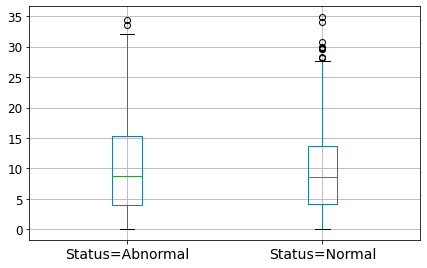

In [244]:
hdf.stratify(['Status']).cols['Vibration_Sensor_1'].boxplot(figsize=(6, 4));
#Ref: https://github.com/dvgodoy/handyspark/blob/master/notebooks/Exploring_Titanic.ipynb Adapted the code from the referenced notebook on github which was used of Titanic dataset.

plt.xticks(fontsize = 14);
plt.yticks(fontsize = 12);
plt.title("");
#plt.savefig('/content/drive/My Drive/00_Asssessment/Spark/figure/box.png', dpi=200);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


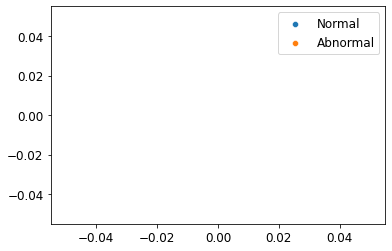

In [245]:
from pyspark .ml. feature import StringIndexer
 
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
label_Indexer = StringIndexer( inputCol ="Status", outputCol ="label")
updated_hdf = label_Indexer.fit(hdf).transform(hdf)

#Plotting Density PLot
plt.figure(figsize=(6, 4))

updated_hdf = data.select("Status","Vibration_Sensor_2").toPandas() #Converted spark dataframe to Pandas()
sns.scatterplot(updated_hdf.Vibration_Sensor_2[updated_hdf.Status=='Normal'], label='Normal')
sns.scatterplot(updated_hdf.Vibration_Sensor_2[updated_hdf.Status=='Abnormal'], label='Abnormal');
plt.xlabel("Vibration_Sensor_2", fontsize = 12)

plt.xticks(fontsize = 12);
plt.yticks(fontsize = 12);
plt.legend(fontsize = 12)
plt.xlabel("");

#Part 3
Using the Apache spark ecosystem, such as pyspark, sparksql or any other component needed, please develop and train a binary logistic regression model to classify the condition of nuclear reactors, i.e. normal or abnormal, based on how they operate. Split the dataset provided into a training (75%) and test (25%) sets. Please use the training set to train your developed model keeping the test set only for evaluating its performance in unseen data

In [246]:
#Binarising the label
#Code adapted from how-to-use guide available form Ref: https://spark.apache.org/docs/latest/ml-features
from pyspark.ml.feature import StringIndexer
labelIndexer = StringIndexer(inputCol="Status", outputCol="label").fit(data)
data = labelIndexer.transform(data)
data.select("Status","label").rdd.takeSample(False, 5, seed=0)

[Row(Status='Normal', label=1.0),
 Row(Status='Abnormal', label=0.0),
 Row(Status='Normal', label=1.0),
 Row(Status='Abnormal', label=0.0),
 Row(Status='Normal', label=1.0)]

In [247]:
#Vectorise the Features
#Code adapted from how-to-use guide available form Ref1: https://spark.apache.org/docs/latest/ml-features and Practical 4: BigDataMSc\_ready\_solutions.ipynb of the module
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
import py4j

data = data.drop(*['Status'])
inputcols = np.array(data.columns)[np.array(data.columns)!='label']
assembler = VectorAssembler(inputCols= inputcols, outputCol = "predictors")

predictors = assembler.transform(data)
model_data = predictors.select("predictors", "label")
model_data.show(5,truncate=False)

+----------------------------------------------------------------------------------------+-----+
|predictors                                                                              |label|
+----------------------------------------------------------------------------------------+-----+
|[4.5044,0.7443,6.34,1.9052,29.5315,0.8647,2.2044,6.048,14.4659,21.648,15.3429,1.2186]   |1.0  |
|[4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483]|1.0  |
|[4.5291,1.0199,6.113,1.0565,26.4271,1.9247,1.942,6.7162,5.3358,11.0779,25.0914,9.2408]  |1.0  |
|[5.1727,1.0007,7.8589,0.2765,25.1576,2.609,2.9234,6.7485,1.9017,1.8463,28.664,4.0157]   |1.0  |
|[5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.37,34.8122,13.4966]  |1.0  |
+----------------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [248]:
from pyspark.ml.classification import RandomForestClassifier
#Ref: Practical 4: BigDataMSc\_ready\_solutions.ipynb of the module 
#Adapted the linear regression model approach used in the practical 4 and applied it to the logistic regression.

train_data, test_data = model_data.randomSplit([0.70,0.30], seed=1)

random_forest = RandomForestClassifier(featuresCol = 'predictors', labelCol=  'label')
random_forest_Model = random_forest.fit(train_data)
#Ref: https://spark.apache.org/docs/latest/ml-classification-regression.html#binomial-logistic-regression

lr_predictions = random_forest_Model.transform(test_data) 
lr_predictions.show(10)

+--------------------+-----+--------------------+--------------------+----------+
|          predictors|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[0.1447,5.5261,7....|  1.0|[6.28448841503363...|[0.31422442075168...|       1.0|
|[0.4724,4.9612,8....|  1.0|[13.5905319304748...|[0.67952659652374...|       0.0|
|[0.8276,11.4771,1...|  1.0|[5.73913415888151...|[0.28695670794407...|       1.0|
|[0.856,4.6408,6.5...|  1.0|[11.1219937012178...|[0.55609968506089...|       0.0|
|[1.1609,4.8175,7....|  1.0|[4.17096331775115...|[0.20854816588755...|       1.0|
|[1.3065,5.3293,7....|  1.0|[8.92348010265440...|[0.44617400513272...|       1.0|
|[1.4502,4.3204,7....|  1.0|[12.2002747207867...|[0.61001373603933...|       0.0|
|[1.5271,5.0052,7....|  1.0|[11.4167808700403...|[0.57083904350201...|       0.0|
|[1.6333,9.2532,10...|  1.0|[11.9684189016022...|[0.59842094508011...|       0.0|
|[1.6681,5.8282,

# Part 4
Use the following three metrics to report the model’s performance, i.e. Precision/Recall, Accuracy and Area under the curve (AUROC). When reporting performance, please only use the test set created by yourselves.

In [249]:
#Evaluation Metrics
lr_pl = lr_predictions.select("prediction","label")
tp = lr_pl[(lr_pl.prediction == 1) & (lr_pl.label == 1)].count()
tn = lr_pl[(lr_pl.prediction == 0) & (lr_pl.label == 0)].count()
fp = lr_pl[(lr_pl.prediction == 0) & (lr_pl.label == 1)].count()
fn = lr_pl[(lr_pl.prediction == 1) & (lr_pl.label == 0)].count()

cm = np.array([[tp, fp], [fn, tn]])
col_name = ["Actual Abnormal", 'Actual Normal']
row_name = ['Predicted Abnormal', 'Predicted Normal']
df_cm = pd.DataFrame(cm, index = [i for i in col_name],
                      columns = [i for i in row_name])

#Code adapted from how-to-use guide available form Ref: https://spark.apache.org/docs/latest/ml-features
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(lr_predictions)

print('Accuracy: ', (tp + tn) / (tp + tn + fp + fn))
print('Precision: ', tp / (tp + fp))
print('Recall: ', tp / (tp + fn))
print('Test Area Under ROC: ', auroc)
print('\n\nConfusion Matrix:\n', df_cm)

Accuracy:  0.8321678321678322
Precision:  0.7943262411347518
Recall:  0.8549618320610687
Test Area Under ROC:  0.9284177060405967


Confusion Matrix:
                  Predicted Abnormal  Predicted Normal
Actual Abnormal                 112                29
Actual Normal                    19               126


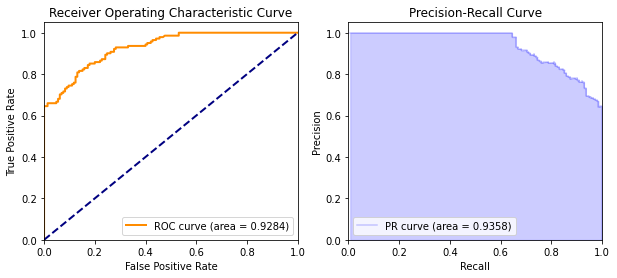

In [250]:
#Plotting ROC and PR Curve
#Code adapted from the below github notebook which was prepared for titanic dataset 
#Ref: https://github.com/dvgodoy/handyspark/blob/master/notebooks/Exploring_Titanic.ipynb
from handyspark import BinaryClassificationMetrics

bcm = BinaryClassificationMetrics(lr_predictions, scoreCol='probability', labelCol='label')
fig, axs = plt.subplots(1, 2, figsize=(10,4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1]);

#plt.savefig('/content/drive/My Drive/00_Asssessment/Spark/figure/roc_lr.png', dpi=200)

### **PART 5 (MULTI-LAYER PERCEPTRON CLASSIFIER)**

Repeat steps 3 and 4 but using a multilayer perceptron classifier this time


In [251]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

if __name__ == "__main__":
    spark = SparkSession\
        .builder.appName("multilayer_perceptron_classification_example").getOrCreate()

inputs = np.array(data.columns)[np.array(data.columns)!= 'label'] #[column for column in h_df.columns ]
print(len(inputs))

layers = [len(inputs), 5, 4, 4, 3 , 2]
# create the trainer and set its parameters
mlp_trainer = MultilayerPerceptronClassifier(featuresCol = 'predictors', labelCol=  'label', maxIter=100, layers=layers, blockSize=128, seed=1)


# train the model
model = mlp_trainer.fit(train_data)

# compute accuracy on the test set
result = model.transform(test_data)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

12
Test set accuracy = 0.6958041958041958


In [252]:
# Evaluating on Test Data
tp = predictionAndLabels[(predictionAndLabels.prediction == 1) & (predictionAndLabels.label == 1)].count()
tn = predictionAndLabels[(predictionAndLabels.prediction == 0) & (predictionAndLabels.label == 0)].count()
fp = predictionAndLabels[(predictionAndLabels.prediction == 0) & (predictionAndLabels.label == 1)].count()
fn = predictionAndLabels[(predictionAndLabels.prediction == 1) & (predictionAndLabels.label == 0)].count()

print('Accuracy: ', (tp + tn) / (tp + tn + fp + fn))

Accuracy:  0.6958041958041958


In [253]:
#Splitting training data into training data and validation data
train_data, val_data = train_data.randomSplit([0.70,0.30], seed=100)
train_data.count(), val_data.count()

(508, 202)

#*Fine Tuning Model*

In [254]:
#Code adapted from how-to-use guide available form Ref: https://spark.apache.org/docs/latest/ml-classification-regression.html
mlp_trainer = MultilayerPerceptronClassifier(featuresCol = 'predictors', labelCol=  'label', maxIter=100, layers=layers, blockSize=128, seed=1)
model = mlp_trainer.fit(train_data)
result = model.transform(val_data)
predictionAndLabels = result.select("prediction", "label")

In [255]:
# Running Iterations for GBT Classifier Model with Validation dataset
accuracy_scores = []
i = 0
for n_iter in range(1,100):
  i +=1
  mlp_trainer = MultilayerPerceptronClassifier(featuresCol = 'predictors', labelCol=  'label', maxIter=n_iter, layers=layers, blockSize=128, seed=1234)
  model = mlp_trainer.fit(train_data)
  result = model.transform(test_data)
  predictionAndLabels = result.select("prediction", "label")

  tp = predictionAndLabels[(predictionAndLabels.prediction == 1) & (predictionAndLabels.label == 1)].count()
  tn = predictionAndLabels[(predictionAndLabels.prediction == 0) & (predictionAndLabels.label == 0)].count()
  fp = predictionAndLabels[(predictionAndLabels.prediction == 0) & (predictionAndLabels.label == 1)].count()
  fn = predictionAndLabels[(predictionAndLabels.prediction == 1) & (predictionAndLabels.label == 0)].count()
  acc = (tp + tn) / (tp + tn + fp + fn)

  print('Iteration:', n_iter, '  Accuracy:', acc)
  accuracy_scores.append(acc) 

Iteration: 1   Accuracy: 0.493006993006993
Iteration: 2   Accuracy: 0.506993006993007
Iteration: 3   Accuracy: 0.506993006993007
Iteration: 4   Accuracy: 0.506993006993007
Iteration: 5   Accuracy: 0.506993006993007
Iteration: 6   Accuracy: 0.506993006993007
Iteration: 7   Accuracy: 0.506993006993007
Iteration: 8   Accuracy: 0.506993006993007
Iteration: 9   Accuracy: 0.506993006993007
Iteration: 10   Accuracy: 0.506993006993007
Iteration: 11   Accuracy: 0.506993006993007
Iteration: 12   Accuracy: 0.506993006993007
Iteration: 13   Accuracy: 0.506993006993007
Iteration: 14   Accuracy: 0.506993006993007
Iteration: 15   Accuracy: 0.506993006993007
Iteration: 16   Accuracy: 0.506993006993007
Iteration: 17   Accuracy: 0.506993006993007
Iteration: 18   Accuracy: 0.5734265734265734
Iteration: 19   Accuracy: 0.5804195804195804
Iteration: 20   Accuracy: 0.5874125874125874
Iteration: 21   Accuracy: 0.6258741258741258
Iteration: 22   Accuracy: 0.5944055944055944
Iteration: 23   Accuracy: 0.59090909

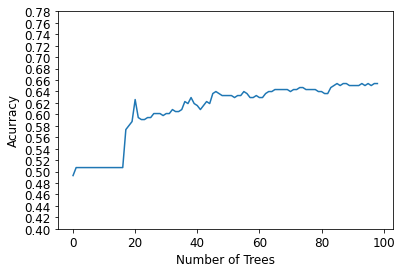

In [257]:
#Plotting Accuracy Scores
plt.plot(accuracy_scores);
plt.xlabel("Number of Trees", fontsize = 12)
plt.ylabel("Acurracy", fontsize = 12)
plt.yticks(np.arange(0.40, 0.80, 0.02), fontsize = 12);
plt.xticks(fontsize = 12);
#plt.savefig('/content/drive/My Drive/00_Asssessment/Spark/figure/gbt_accuracy.png', dpi=200)

In [258]:
mlp_trainer = MultilayerPerceptronClassifier(featuresCol = 'predictors', labelCol=  'label', maxIter=n_iter, layers=layers, blockSize=128, seed=1234)
model = mlp_trainer.fit(train_data)
result = model.transform(test_data)
predictionAndLabels = result.select("prediction", "label")

In [260]:
tp = predictionAndLabels[(predictionAndLabels.prediction == 1) & (predictionAndLabels.label == 1)].count()
tn = predictionAndLabels[(predictionAndLabels.prediction == 0) & (predictionAndLabels.label == 0)].count()
fp = predictionAndLabels[(predictionAndLabels.prediction == 0) & (predictionAndLabels.label == 1)].count()
fn = predictionAndLabels[(predictionAndLabels.prediction == 1) & (predictionAndLabels.label == 0)].count()

cm = np.array([[tp, fp], [fn, tn]])
col_name = ["Actual Abnormal", 'Actual Normal']
row_name = ['Predicted Abnormal', 'Predicted Normal']
df_cm = pd.DataFrame(cm, index = [i for i in col_name],
                      columns = [i for i in row_name])

#Code adapted from how-to-use guide available form Ref: https://spark.apache.org/docs/latest/ml-features
auroc = evaluator.evaluate(result)

print('Accuracy: ', (tp + tn) / (tp + tn + fp + fn))
print('Precision: ', tp / (tp + fp))
print('Recall: ', tp / (tp + fn))
print('Test Area Under ROC: ', auroc)
print('\n\nConfusion Matrix:\n', df_cm)

Accuracy:  0.6538461538461539
Precision:  0.6099290780141844
Recall:  0.6615384615384615
Test Area Under ROC:  0.6538461538461539


Confusion Matrix:
                  Predicted Abnormal  Predicted Normal
Actual Abnormal                  86                55
Actual Normal                    44               101


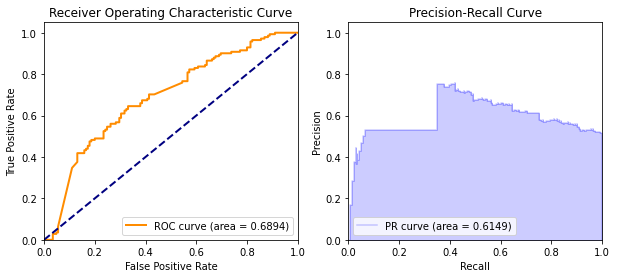

In [261]:
bcm = BinaryClassificationMetrics(result, scoreCol='probability', labelCol='label')
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1]);

#plt.savefig('/content/drive/My Drive/00_Asssessment/Spark/figure/roc_gbt_test.png', dpi=200)